In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from IPython.display import display
from IPython.display import set_matplotlib_formats
import datetime
import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
import os
import warnings
import gc
import copy
set_matplotlib_formats('svg')

#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 200)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
%%time
# ['销售订单编号', '物料编号', '是否三包描述', '基本计量单位', '产品组名称', '产品组代码', 
# '创建日期', 'year', 'month', 'week', 'day', 'weekday', '订单数量', '订单金额', '物料描述', 
# '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间', '设备类型']
df = pd.read_csv('gongqi.csv', encoding='utf-8-sig',
                 usecols=['销售订单编号', '物料编号', '是否三包描述', '基本计量单位', 
                          '创建日期', 'year', 'month', 'day', 
                          '订单数量', '订单金额', 
                          '物料描述', '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况', '吨位区间', '设备类型'])
print('物料编号数量：', len(df['物料编号'].unique()))
print('订单属性包括：', df.columns)

# 存在订单金额为0的订单，三包单或者赠送订单，不好处理
# 物料类别有冲突这里只取一种类别，后续让业务解决冲突
# 先不管这些问题，不做筛选，一起来整体看看

# 考虑去掉订单金额为0的订单，赠送订单
print('订单金额为0的疑似赠送订单数：', len(df.loc[df['订单金额']==0]))
# df = df.loc[df['订单金额']!=0]

# 考虑三包件
display(df['是否三包描述'].value_counts())
print(len(df.loc[df['是否三包描述']=='三包申请单', '物料编号'].unique()))
print(len(df.loc[df['是否三包描述']=='销售申请', '物料编号'].unique()))

# 根据订单金额和数量求出物料单价，以此作为成本
df['物料单价'] = df['订单金额'] / df['订单数量']

# 部分物料类别合并
# 不确定合并的对不对，另外还有诸如吊臂、支腿、两室、等不确定要不要合并
df.loc[df['物料类别']=='液压件', '物料类别'] = '液压件类'
df.loc[df['物料类别']=='大型结构件', '物料类别'] = '大型结构件类'
df.loc[df['物料类别']=='小型结构件(含非锻件五金件)', '物料类别'] = '小型结构件'
df.loc[df['物料类别']=='弹簧类', '物料类别'] = '弹簧件类'

物料编号数量： 20311
订单属性包括： Index(['销售订单编号', '物料编号', '是否三包描述', '基本计量单位', '创建日期', 'year', 'month', 'day',
       '订单数量', '订单金额', '物料描述', '是否进口件', '物料类别', '周期（天）下计划后的交货周期', '在产情况',
       '吨位区间', '设备类型'],
      dtype='object')
订单金额为0的疑似赠送订单数： 52527


销售申请     256221
三包申请单     18616
Name: 是否三包描述, dtype: int64

4376
19337
Wall time: 1.6 s


In [3]:
# 构造包含完整月份的订单数据，没有的月份订单数量补0
# 无物料类别信息等业务信息的，补未知
def struct_full_month_df(df):
    full_month_df = pd.DataFrame(product(df['物料编号'].unique(), 
                         np.sort(df['year'].unique()),
                         np.sort(df['month'].unique())),
                columns=['物料编号', 'year', 'month'])
    temp1 = df.groupby(['物料编号', 'year', 'month'], as_index=False)['订单数量'].agg({'月订单数量':'sum'})
    temp2 = df.groupby(['物料类别', '物料编号'], as_index=False).count()
    temp3 = df.groupby(['基本计量单位', '物料编号'], as_index=False).count()
    temp4 = df.groupby(['是否进口件', '物料编号'], as_index=False).count()
    temp5 = df.groupby(['周期（天）下计划后的交货周期', '物料编号'], as_index=False).count()
    temp6 = df.groupby(['在产情况', '物料编号'], as_index=False).count()
    temp7 = df.groupby(['物料描述', '物料编号'], as_index=False).count()
    temp8 = df.groupby(['吨位区间', '物料编号'], as_index=False).count()
    temp9 = df.groupby(['设备类型', '物料编号'], as_index=False).count()
    temp10 = df.groupby(['物料编号'], as_index=False)['物料单价'].agg({'物料单位成本':'max'})
    full_month_df = pd.merge(full_month_df, temp1, on=['物料编号', 'year', 'month'], how='left')
    full_month_df = pd.merge(full_month_df, temp2[['物料类别', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp3[['基本计量单位', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp4[['是否进口件', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp5[['周期（天）下计划后的交货周期', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp6[['在产情况', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp7[['物料描述', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp8[['吨位区间', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp9[['设备类型', '物料编号']], on=['物料编号'], how='left')
    full_month_df = pd.merge(full_month_df, temp10, on=['物料编号'], how='left')
    full_month_df['月订单数量'].fillna(0, inplace=True)
    full_month_df.fillna('未知', inplace=True)
    return full_month_df

def plot_monthly(data, ylabel='月订单数量', title='各年份各类配件需求总量随月份变化图'):
    
    plt.figure(figsize=(10, 3))
    x = data['date']
    y = data[ylabel]
#     plt.plot(x, y)
    plt.bar(x, y, width=5)
    plt.xticks(fontsize=10)    
    plt.yticks(fontsize=10) 
    plt.xlabel('月份', fontsize=10)    
    plt.ylabel('需求', fontsize=10)
    plt.title(title, fontsize=10)
    plt.grid()
    plt.gcf().autofmt_xdate() # 自动旋转日期标记
    plt.show()

# 思路1：计算需求间隔平均值
# 注意计算间隔的方式，算序列前面的0，不算序列后面的0，只要没到非0值就一直计数，到非0值就重新计数
# 定义是否合理，如果序列后面有很多0呢？？？？后续应该在序列最后补一个非0值来计算间隔，也有问题？？？？
# 平均间隔单独看有各种问题，需要考虑结合0值的比例，平均值等信息
# def interval_mean(input_endog):
    
#     input_series = np.asarray(input_endog)
# #     input_length = len(input_series)
#     nzd = np.where(input_series != 0)[0] # find location of non-zero demand
# #     z = input_series[nzd] # demand
#     x = np.concatenate([[nzd[0]], np.diff(nzd)]) # intervals
#     # input_series = [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]
#     # nzd = [ 5  6  8 11 16]
#     # x = [5 1 2 3 5]
#     p = np.mean(x)
#     if list(nzd) == []: # 序列里全是0，此时，均值为0，方差为0，间隔为nan
#         p = np.nan
#     if list(nzd) == [0]: # 序列开头非0，后面全是0，此时，间隔给一个大值，20？
#         p = 20
#     # 输出求间隔平均值
#     return p

# 思路2：计算需求间隔平均值
# 考虑几个特殊情况，如果不处理，对平均间隔计算有较大影响
def interval_mean(input_endog):
    
    input_series = np.asarray(input_endog)
    # 考虑序列全0的情况，定义间隔长度为序列长度
    if np.isin(input_series, [0]).all():
        return len(input_series)
    # 考虑序列后面一个或多个0结尾的情况，补一个0来定义间隔长度
    # 补0操作这种合理吗，比如[0,0,0,0,0,0,1,0]和[0,0,0,0,0,0,0,1]的平均间隔就有一定差距
    if input_series[-1]==0:
        input_series = np.append(input_series, 1)
    nzd = np.where(input_series != 0)[0] # find location of non-zero demand
    if nzd[0]!=0:
        x = np.concatenate([[nzd[0]+1], np.diff(nzd)]) # intervals
    else:
        # 考虑序列开头为非0的情况，按照上面的代码会计算出间隔为0，这里针对这种情况特殊处理
        x = np.diff(nzd)
    p = np.mean(x)
    # 输出求间隔平均值
    return p

In [4]:
%%time
matrl_full = struct_full_month_df(df)
print(len(matrl_full))
matrl_full.head()

487464
Wall time: 6.32 s


,物料编号,year,month,月订单数量,物料类别,基本计量单位,是否进口件,周期（天）下计划后的交货周期,在产情况,物料描述,吨位区间,设备类型,物料单位成本
0,00630736400001010,2020,1,4.0,电器件类,PC,否,12,停产,槽型板,大吨位,汽车吊,37.81
1,00630736400001010,2020,2,4.0,电器件类,PC,否,12,停产,槽型板,大吨位,汽车吊,37.81
2,00630736400001010,2020,3,4.0,电器件类,PC,否,12,停产,槽型板,大吨位,汽车吊,37.81
3,00630736400001010,2020,4,0.0,电器件类,PC,否,12,停产,槽型板,大吨位,汽车吊,37.81
4,00630736400001010,2020,5,0.0,电器件类,PC,否,12,停产,槽型板,大吨位,汽车吊,37.81


In [5]:
%%time
# 计算每个物料的各种统计量，以及保留相关业务属性（物料类别、计量单位等）
matrl_stats = matrl_full.groupby('物料编号', as_index=False)['月订单数量'].agg({'单配件月需求均值':'mean'})
matrl_stats['单配件月需求最大值'] = matrl_full.groupby('物料编号')['月订单数量'].max().values
matrl_stats['单配件月需求标准差'] = matrl_full.groupby('物料编号')['月订单数量'].std().values
matrl_stats['单配件月需求变异系数'] = matrl_stats['单配件月需求标准差'] / matrl_stats['单配件月需求均值']
matrl_stats['需求平均间隔'] = matrl_full.groupby('物料编号')['月订单数量'].apply(interval_mean).values

# 把月订单数量的0值转换为空值，方便统计非0统计量
matrl_full.loc[matrl_full['月订单数量']==0, '月订单数量'] = np.nan
matrl_stats['单配件月非0需求均值'] = matrl_full.groupby('物料编号')['月订单数量'].mean().values
matrl_stats['单配件月非0需求标准差'] = matrl_full.groupby('物料编号')['月订单数量'].std().values
matrl_stats['单配件月非0需求变异系数'] = matrl_stats['单配件月非0需求标准差'] / matrl_stats['单配件月非0需求均值']

matrl_stats['单月0需求比例'] = 1 - matrl_full.groupby('物料编号')['月订单数量'].count().values / 24
# 统计完以后，把月订单数量的空值重新填0
matrl_full['月订单数量'].fillna(0, inplace=True)

# 加上业务信息
id_class = matrl_full.groupby(['物料编号','物料类别'],as_index=False).count()[['物料编号','物料类别']]
matrl_stats = pd.merge(matrl_stats, id_class, on='物料编号', how='left')
id_measuring = matrl_full.groupby(['物料编号','基本计量单位'],as_index=False).count()[['物料编号','基本计量单位']]
matrl_stats = pd.merge(matrl_stats, id_measuring, on='物料编号', how='left')
id_description = matrl_full.groupby(['物料编号','物料描述'],as_index=False).count()[['物料编号','物料描述']]
matrl_stats = pd.merge(matrl_stats, id_description, on='物料编号', how='left')
id_entrance = matrl_full.groupby(['物料编号','是否进口件'],as_index=False).count()[['物料编号','是否进口件']]
matrl_stats = pd.merge(matrl_stats, id_entrance, on='物料编号', how='left')
id_period = matrl_full.groupby(['物料编号','周期（天）下计划后的交货周期'],as_index=False).count()[['物料编号','周期（天）下计划后的交货周期']]
matrl_stats = pd.merge(matrl_stats, id_period, on='物料编号', how='left')
id_in_production = matrl_full.groupby(['物料编号','在产情况'],as_index=False).count()[['物料编号','在产情况']]
matrl_stats = pd.merge(matrl_stats, id_in_production, on='物料编号', how='left')
id_tonnage = matrl_full.groupby(['物料编号','吨位区间'],as_index=False).count()[['物料编号','吨位区间']]
matrl_stats = pd.merge(matrl_stats, id_tonnage, on='物料编号', how='left')
id_type = matrl_full.groupby(['物料编号','设备类型'],as_index=False).count()[['物料编号','设备类型']]
matrl_stats = pd.merge(matrl_stats, id_type, on='物料编号', how='left')
id_money = matrl_full.groupby(['物料编号'],as_index=False)['物料单位成本'].agg({'物料单位成本':'max'})
matrl_stats = pd.merge(matrl_stats, id_money, on='物料编号', how='left')

Wall time: 8.19 s


一、先考虑在产情况，停产的无需考虑，未知先不考虑，只保留在产的配件进行后续分类

In [6]:
matrl_stats['在产情况'].value_counts()

停产    9466
在产    9157
未知    1688
Name: 在产情况, dtype: int64

二、考虑不同订单类型，三包、销售、赠送

In [7]:
display(df['是否三包描述'].value_counts())
print('疑似赠送订单：', len(df.loc[df['订单金额']==0]))

销售申请     256221
三包申请单     18616
Name: 是否三包描述, dtype: int64

疑似赠送订单： 52527


三、考虑是否进口件，进口件类别较少且交货周期长

In [8]:
display(matrl_stats.loc[matrl_stats['是否进口件']=='是', '物料类别'].value_counts())
display(matrl_stats.loc[matrl_stats['是否进口件']=='是', '周期（天）下计划后的交货周期'].value_counts())
display(matrl_stats.loc[matrl_stats['是否进口件']=='否', '周期（天）下计划后的交货周期'].value_counts())

泵和阀类        128
发动机类        119
传动件传动操纵类     79
一般结构件类       61
滤芯类          31
钢丝绳类         27
电器件类         18
底盘车桥类        10
马达类           8
减速机           7
管和接头类         5
油品类           5
液压件类          4
国标件           3
弹簧件类          1
油缸类           1
气动元件类         1
Name: 物料类别, dtype: int64

90.0     497
150.0     11
Name: 周期（天）下计划后的交货周期, dtype: int64

8.0     4087
12.0    3666
6.0     3235
10.0    2930
14.0    1524
4.0      626
13.0     521
17.0     471
16.0     423
40.0     115
9.0      111
20.0      95
18.0      69
35.0      61
30.0      56
19.0      28
22.0      28
70.0      24
11.0      21
15.0       6
45.0       6
65.0       5
90.0       3
7.0        2
3.0        2
Name: 周期（天）下计划后的交货周期, dtype: int64

四、考虑计量单位，一些事实上非配件的物料（单位为米、平方米、立方米、毫升、毫米、公斤、升等）可以另外考虑，如油品、图册等，  
<big>**另外好像存在不少计量单位不规范的物料，这会很大的影响对需求量的统计**</big>

In [9]:
# 不同品类的计量单位
# 需要考虑不同计量单位的影响
display(matrl_stats['基本计量单位'].value_counts())
display(matrl_stats.groupby(['物料类别', '基本计量单位'], as_index=False)['物料编号'].agg({'物料数': 'count'}))

# 部分物料的计量单位可能存在错误，需矫正
# 计量单位存疑物料
# matrl_stats.loc[(matrl_stats['物料类别']=='一般结构件类') & (matrl_stats['基本计量单位']=='KG')]
# matrl_stats.loc[(matrl_stats['物料类别']=='两室配件') & (matrl_stats['基本计量单位']=='KG')]
# matrl_stats.loc[(matrl_stats['物料类别']=='传动件传动操纵类') & (matrl_stats['基本计量单位']=='KG')]
# matrl_stats.loc[(matrl_stats['物料类别']=='发动机类') & (matrl_stats['基本计量单位']=='L')] # 或许应该放到油品类
# matrl_stats.loc[(matrl_stats['物料类别']=='标牌图册类') 
#                 & ((matrl_stats['基本计量单位']=='MM') | (matrl_stats['基本计量单位']=='M'))] # 反光标识膜这种单位很小，导致突然的数值很大
# matrl_stats.loc[(matrl_stats['物料类别']=='泵和阀类') & (matrl_stats['基本计量单位']=='KG')]
# matrl_stats.loc[(matrl_stats['物料类别']=='电器件类') & (matrl_stats['基本计量单位']=='KG')]

PC     19631
EA       550
KG        51
M         49
L         24
MM         2
TAO        2
TAI        1
M3         1
Name: 基本计量单位, dtype: int64

,物料类别,基本计量单位,物料数
0,一般结构件类,EA,1
1,一般结构件类,KG,2
2,一般结构件类,PC,4358
3,两室,PC,105
4,两室配件,EA,1
5,两室配件,KG,7
6,两室配件,PC,646
7,传动件传动操纵类,EA,66
8,传动件传动操纵类,KG,3
9,传动件传动操纵类,PC,773


五、包括新进入市场的配件和退出市场的配件，以及生产期的配件：  
退出市场的配件即停产配件，不需要考虑；  
新进入市场的配件也可能非0需求频次较低，最好还是有业务告知，销售月份较少的时候不预测或简单方法预测，结合量、价值和重要性选择备货策略；  
<big>**这里会引出增量训练的问题，新配件如何处理，新月份数据如何增量训练？**</big>

In [10]:
# 从订单数据的角度考虑新旧配件
new_old_df = copy.deepcopy(matrl_full[['物料编号', 'year', 'month', '月订单数量']])
new_old_df['year_month'] = (new_old_df['year']-2020)*12+new_old_df['month']
new_old_df.loc[new_old_df['月订单数量']==0, '月订单数量'] = np.nan
new_old_df = new_old_df.pivot(index='物料编号', columns='year_month', values='月订单数量')
# display(new_old_df)

# 考虑前12个月非0数，后12个月的非0数
total_nums = new_old_df.sum(axis=1).to_frame("nums").reset_index()
total_top12nozeros = np.sum(~new_old_df.iloc[:,:12].isnull(),axis=1).to_frame("top12nozeros").reset_index()
total_tail12nozeros = np.sum(~new_old_df.iloc[:,-12:].isnull(),axis=1).to_frame("tail12nozeros").reset_index()
tt = pd.merge(total_nums, total_top12nozeros, on='物料编号')
tt = pd.merge(tt, total_tail12nozeros, on='物料编号')

tt['配件生命周期'] = '生产期'
tt.loc[(tt['nums']>100) & (tt['top12nozeros']<5) & (tt['tail12nozeros']>5), '配件生命周期'] = '新配件'
tt.loc[(tt['nums']>100) & (tt['top12nozeros']>5) & (tt['tail12nozeros']<5), '配件生命周期'] = '老配件'
display(tt['配件生命周期'].value_counts())

生产期    20113
新配件      156
老配件       42
Name: 配件生命周期, dtype: int64

六、考虑需求为非0的频次，24个月若非0需求的频次小于等于4（待定），没有预测的必要；另外这一部分不需要预测的结合物料的价值和重要性可采用少量备货或不备货的策略

In [11]:
print(len(matrl_stats.loc[(matrl_stats['在产情况']=='在产') & (matrl_stats['单月0需求比例']<=0.8)]))
matrl_stats.loc[(matrl_stats['在产情况']=='在产') & (matrl_stats['单月0需求比例']<=0.8), '物料类别'].value_counts()

2452


一般结构件类       460
国标件          345
管和接头类        257
橡塑尼龙类        213
泵和阀类         194
钢丝绳类         132
传动件传动操纵类     126
油缸类          113
轴承类          109
发动机类          86
电器件类          64
润滑与密封类        52
液压件类          36
辅材杂件类         36
两室            28
吊臂(伸缩)        25
减速机           23
起重设备类         20
油品类           20
弹簧件类          20
小型结构件         16
标牌图册类         15
气动元件类         13
马达类           12
大型结构件类        10
滤芯类           10
吊臂(基本/顶节)      7
异型臂            4
两室配件           3
标准节            2
支腿(活动)         1
Name: 物料类别, dtype: int64

七、LLamasoft方案，结合需求量、频次（间隔）、方差波动分类

In [12]:
# 先按照LLamasoft的需求分类进行试分类，中间部分参数只能猜测

matrl_stats['分类'] = np.nan

# 24个月只有少量几个月有需求，这样的配件也无法预测，暂定为4(对应单月0需求比例大于0.8左右)
matrl_stats.loc[(matrl_stats['单月0需求比例']>0.8), '分类'] = 'Extremely Slow/Unpredictable'
matrl_stats.loc[(matrl_stats['单月0需求比例']<=0.8) & 
                (matrl_stats['单配件月非0需求标准差']>=10) & 
                (matrl_stats['单配件月需求最大值']>=10*matrl_stats['单配件月非0需求均值']), 
                '分类'] = 'Outlier'
matrl_stats.loc[(matrl_stats['分类']!='Extremely Slow/Unpredictable') & 
                (matrl_stats['分类']!='Outlier') & 
                (matrl_stats['需求平均间隔']<1.32) &
                (matrl_stats['单配件月非0需求变异系数']<0.7), 
                '分类'] = 'Non-Intermittent Smooth'
matrl_stats.loc[(matrl_stats['分类']!='Extremely Slow/Unpredictable') & 
                (matrl_stats['分类']!='Outlier') & 
                (matrl_stats['需求平均间隔']<1.32) &
                (matrl_stats['单配件月非0需求变异系数']>=0.7), 
                '分类'] = 'Non-Intermittent Erratic'
matrl_stats.loc[(matrl_stats['分类']!='Extremely Slow/Unpredictable') & 
                (matrl_stats['分类']!='Outlier') & 
                (matrl_stats['需求平均间隔']>=1.32) &
                (matrl_stats['单配件月非0需求标准差']<4) & 
                (matrl_stats['单配件月非0需求变异系数']<0.7), 
                '分类'] = 'Intermittent Low Variable Slow'
matrl_stats.loc[(matrl_stats['分类']!='Extremely Slow/Unpredictable') & 
                (matrl_stats['分类']!='Outlier') & 
                (matrl_stats['需求平均间隔']>=1.32) &
                (matrl_stats['单配件月非0需求标准差']<4) & 
                (matrl_stats['单配件月非0需求变异系数']>=0.7), 
                '分类'] = 'Intermittent Low Variable Lumpy'
matrl_stats.loc[(matrl_stats['分类']!='Extremely Slow/Unpredictable') & 
                (matrl_stats['分类']!='Outlier') & 
                (matrl_stats['需求平均间隔']>=1.32) &
                (matrl_stats['单配件月非0需求标准差']>=4) & 
                (matrl_stats['单配件月非0需求变异系数']<0.7), 
                '分类'] = 'Intermittent High Variable Slow'
matrl_stats.loc[(matrl_stats['分类']!='Extremely Slow/Unpredictable') & 
                (matrl_stats['分类']!='Outlier') & 
                (matrl_stats['需求平均间隔']>=1.32) &
                (matrl_stats['单配件月非0需求标准差']>=4) & 
                (matrl_stats['单配件月非0需求变异系数']>=0.7), 
                '分类'] = 'Intermittent High Variable Lumpy'

In [13]:
display(matrl_stats['分类'].value_counts())
display(matrl_stats.loc[(matrl_stats['在产情况']=='在产') & (matrl_stats['单月0需求比例']<=0.8), '分类'].value_counts())

Extremely Slow/Unpredictable        15986
Intermittent Low Variable Slow       2039
Intermittent High Variable Lumpy      824
Intermittent Low Variable Lumpy       594
Non-Intermittent Smooth               337
Non-Intermittent Erratic              307
Intermittent High Variable Slow       211
Outlier                                13
Name: 分类, dtype: int64

Intermittent Low Variable Slow      1051
Intermittent High Variable Lumpy     542
Intermittent Low Variable Lumpy      324
Non-Intermittent Smooth              203
Non-Intermittent Erratic             181
Intermittent High Variable Slow      139
Outlier                               12
Name: 分类, dtype: int64

In [14]:
class_df = matrl_stats.loc[
    (matrl_stats['在产情况']=='在产') 
    & (matrl_stats['单月0需求比例']<=0.8)].groupby(['物料类别', '分类'], as_index=False).count()[['物料类别', '分类', '物料编号']]
class_df

,物料类别,分类,物料编号
0,一般结构件类,Intermittent High Variable Lumpy,65
1,一般结构件类,Intermittent High Variable Slow,16
2,一般结构件类,Intermittent Low Variable Lumpy,65
3,一般结构件类,Intermittent Low Variable Slow,263
4,一般结构件类,Non-Intermittent Erratic,25
5,一般结构件类,Non-Intermittent Smooth,26
6,两室,Intermittent Low Variable Lumpy,1
7,两室,Intermittent Low Variable Slow,22
8,两室,Non-Intermittent Erratic,1
9,两室,Non-Intermittent Smooth,4


八、考虑成本和价值、重要性等，分物料类别，考虑物料描述，考虑设备类别和吨位，可能需要合并或者进一步细分

In [15]:
# 从各类物料销售金额来看，履带吊的成本高于汽车吊，大吨位区间的成本高于小吨位的
# 
def rename(newname):
    def decorator(f):
        f.__name__ = newname
        return f
    return decorator

def q_at(y):
    @rename(f'q{y:0.2f}')
    def q(x):
        return x.quantile(y)
    return q

f = {'物料单位成本': 
     [q_at(0.1), q_at(0.25), q_at(0.5), q_at(0.75), q_at(0.8), q_at(0.9), q_at(0.95), q_at(0.98), q_at(0.99), q_at(1)]}
display(matrl_stats.loc[(matrl_stats['在产情况']=='在产') & (matrl_stats['单月0需求比例']<=0.8)].groupby('物料类别').agg(f).round(2))
display(matrl_stats.groupby('物料类别').agg(f).round(2))

display(matrl_stats.groupby('设备类型').agg(f).round(2))
display(matrl_stats.groupby(['设备类型', '吨位区间']).agg(f).round(2))
display(matrl_stats.groupby(['设备类型', '吨位区间', '物料类别']).agg(f).round(2))

物料单位成本                                                         \
               q0.10      q0.25      q0.50      q0.75      q0.80      q0.90   
物料类别                                                                          
一般结构件类         11.72      31.33     140.00     611.00     828.00    1299.68   
两室          15392.60   18663.25   23596.00   38994.00   40479.00   43133.72   
两室配件            1.36       1.43       1.54      45.27      54.02      71.51   
传动件传动操纵类       32.41     270.75     923.00    1808.75    2299.00    7526.00   
减速机          5981.80    7525.50    9920.85   22441.00   30564.00   43233.20   
发动机类           71.50     210.00     593.00    1638.25    2047.00    4026.00   
吊臂(伸缩)      16269.14   16900.00   19536.00   22661.00   23780.25   26015.26   
吊臂(基本/顶节)    2411.60   15382.50   29997.00   34124.34   35831.54   45146.73   
国标件             0.04       0.08       0.25       1.29       2.59       5.88   
大型结构件类        918.60    1438.25   15333.00   26611.00   29014.80   37087.54   
小型结构件         310.00     425.00     559.00    1080.25    1099.00    3178.50   
异型臂         10087.34   11173.55  187401.50  380920.00  391656.40  413129.20   
弹簧件类            2.77       3.11       9.60      12.02      12.71      15.02   
支腿(活动)      38438.40   38438.40   38438.40   38438.40   38438.40   38438.40   
标准节        368346.70  371643.25  377137.50  382631.75  383730.60  385928.30   
标牌图册类           3.85      18.20      33.12      54.50      55.00      77.80   
橡塑尼龙类           8.48      26.22      78.00     124.00     139.00     290.40   
气动元件类          72.29     240.00     283.00     648.00     834.60    1591.80   
油品类             7.20      11.76      20.27      30.82      40.74      77.90   
油缸类          1386.08    2386.00    5237.00   22330.00   25991.30   36896.40   
泵和阀类          180.10     666.75    1604.50    4474.25    5218.60    8137.40   
润滑与密封类          1.32       2.33      37.35      98.00     119.20     487.28   
液压件类          191.50     621.50    1515.00    5244.50    5694.00    6337.00   
滤芯类           154.17     312.14     476.00    2284.43    2381.60    2535.90   
电器件类            0.60      14.41     176.50     844.75     944.40    2053.40   
管和接头类           4.42       9.16      36.03     105.00     145.00     220.40   
起重设备类        1560.60    2766.75    6312.00   11739.29   12279.53   16618.50   
轴承类            11.74      22.02      58.00     148.00     197.60     351.40   
辅材杂件类           3.62       9.08      22.12      45.07      51.00      70.00   
钢丝绳类           97.20     369.00    1340.48    3952.50    5135.60   16676.90   
马达类          3165.40    4081.00    5075.64   10308.75   17665.00   23031.00   

                                                       
               q0.95      q0.98      q0.99      q1.00  
物料类别                                                   
一般结构件类       1969.10    2609.12    4384.15   13702.00  
两室          46589.45   47446.70   47499.35   47552.00  
两室配件           80.25      85.50      87.25      89.00  
传动件传动操纵类    12401.69   15795.50   22408.02   27051.00  
减速机        119065.60  246434.00  293217.00  340000.00  
发动机类         7045.26   38425.80  104878.00  162933.00  
吊臂(伸缩)      28042.53   31531.24   32980.12   34429.00  
吊臂(基本/顶节)   51279.51   54959.19   56185.74   57412.30  
国标件            17.61      30.16      41.43     111.00  
大型结构件类      69116.49   88333.86   94739.65  101145.44  
小型结构件        7929.25   13095.70   14817.85   16540.00  
异型臂        423865.60  430307.44  432454.72  434602.00  
弹簧件类           33.62      36.22      37.08      37.95  
支腿(活动)      38438.40   38438.40   38438.40   38438.40  
标准节        387027.15  387686.46  387906.23  388126.00  
标牌图册类         109.80     133.32     141.16     149.00  
橡塑尼龙类         677.20    1269.12    1787.44    2436.00  
气动元件类        3049.20    4218.48    4608.24    4998.00  
油品类           136.25     298.70     352.85     407.00  
油缸类         71276.88  110618.76  145203.64  177533.00  
泵和阀类        11729.50   20777.88   25959

物料单位成本                                                       \
              q0.10     q0.25     q0.50      q0.75      q0.80      q0.90   
物料类别                                                                       
一般结构件类         4.46     22.52    117.00     542.00     756.00    1240.00   
两室         16854.00  20225.00  33449.00   38990.00   39397.64   41420.80   
两室配件          11.78     46.19    122.00     416.78     535.00    1148.00   
传动件传动操纵类       0.00     34.74    309.50    1675.56    2257.40   12728.90   
减速机            0.00   7455.75  13018.00   39733.00   57929.00   79574.10   
发动机类           4.52     53.00    315.00    1442.50    1981.40    6848.80   
吊臂(伸缩)     16305.00  19501.00  27663.00   71982.00   82878.40  119940.60   
吊臂(基本/顶节)   1827.00   3285.75  31270.50   57371.23   71208.58  146319.00   
国标件            0.04      0.11      0.67       3.99       6.44      19.68   
大型结构件类       321.70   3611.50  11307.00   20159.50   24512.54   39403.70   
小型结构件          0.00     24.84    171.00     863.00    1083.25    2521.89   
履带架            0.00      0.00  18801.45  118779.00  124440.96  135764.88   
底盘车桥类          0.00      9.26     85.00     385.50     554.60    2595.67   
异型臂         1110.06   6889.64  41228.68  133500.49  167716.00  309813.83   
弹簧件类           1.41      3.47      9.73      37.95      51.05      87.60   
支腿(固定)         0.00    972.94   4479.00   12839.50   12931.00   17691.54   
支腿(活动)         0.00  14997.50  23049.85   32425.00   33931.20   42752.48   
未知             0.00     10.43    104.50     698.21    1152.00   12606.40   
标准节         8235.60  16782.22  61709.00  169527.08  207656.00  288982.00   
标牌图册类          0.90      2.04     11.18      37.49      54.80      92.70   
桅杆           507.60   2704.26  39698.00  149560.90  174557.80  192870.88   
橡塑尼龙类          4.13     25.50     67.00     114.00     127.40     221.80   
气动元件类         17.26     82.46    246.50     659.50     877.00    1457.90   
油品类            7.35     14.03     36.15     258.72     288.20     437.40   
油缸类          421.44   1797.62   5753.00   22476.65   26380.00   45270.00   
泵和阀类          90.00    379.00   1037.02    3955.75    5078.44   10504.20   
润滑与密封类         0.38     20.17    149.50     525.00     673.00    1237.03   
液压件类           6.54    122.00    720.00    3750.00    4531.40    6792.20   
滤芯类           53.00     95.75    173.00     358.40     411.00     931.00   
电器件类           2.34     37.86    240.00    1126.00    1582.44    4998.80   
管和接头类          6.24     23.71     69.00     153.00     182.00     284.00   
起重设备类        557.50   4900.50  15737.18   26214.75   39651.00   87636.62   
车架         20511.00  44751.00  91545.00  395074.00  408876.20  436480.60   
转台           101.72   1867.25  14668.45   64403.45   72979.95  180501.50   
轴承类           10.79     30.14     77.00     213.84     279.20     594.04   
辅材杂件类          0.00      5.20     19.14      31.91      34.46      68.00   
钢丝绳类          72.00    282.00   1285.00    4845.50    6764.95   23371.00   
锻件(表面处理)     444.40   1300.66   1695.00    2160.50    2306.80    2699.30   
马达类          722.50   3210.75   5687.50   20340.00   20520.00   38191.82   

                                                          
               q0.95       q0.98       q0.99       q1.00  
物料类别                                                      
一般结构件类       2150.80     4863.20     9560.20   458455.00  
两室          44594.80    47536.40    48252.80    49199.00  
两室配件         2103.60     3369.94     4381.07    21476.65  
传动件传动操纵类    26983.37    85161.26   133207.45   508155.00  
减速机         97383.70   122580.90   214536.50   340000.00  
发动机类        15041.50    75740.24   124830.32   479587.00  
吊臂(伸缩)     141117.80   183530.84   200471.72   582076.00  
吊臂(基本/顶节)  194825.75   357273.80   646622.00  1595646.00  
国标件            45.26      134.00      400.98     4801.00  
大型结构件类      62968.82   102900.66   127582.83   226689.00  
小型结构件        5757.12    20138.40    44691.48   324465

物料单位成本                                                                \
      q0.10  q0.25  q0.50    q0.75   q0.80     q0.90     q0.95      q0.98   
设备类型                                                                        
履带吊    3.72  48.32  348.0  3224.15  5936.0  25785.03  91225.03  222981.80   
未知     0.00  10.43  104.5   698.21  1152.0  12606.40  49145.30  137783.50   
汽车吊    1.29  23.40  121.0   790.20  1190.4   6563.40  22831.56   54869.76   

                            
          q0.99      q1.00  
设备类型                        
履带吊   338836.66  1936200.0  
未知    243340.27  1072384.0  
汽车吊    93096.36  1595646.0

物料单位成本                                           \
                      q0.10     q0.25     q0.50     q0.75      q0.80   
设备类型 吨位区间                                                              
履带吊  0                 0.00  28048.85  45821.02  74779.55   78740.40   
     中小吨位(履320T 及以下)   2.62     26.75    147.00   1045.00    1771.16   
     大吨位(履350-800T)    8.83     82.20    486.62   3896.75    6550.00   
     超大吨位(履800T 及以上)   0.00    192.00   1882.49  80732.78  110217.00   
未知   未知                0.00     10.43    104.50    698.21    1152.00   
汽车吊  中小吨位              0.10      2.98     70.00   1125.75    3093.00   
     大吨位               5.86     35.88    139.00    771.76    1103.20   
     超大吨位              1.32     15.72     95.00    638.75    1033.28   

                                                                              
                          q0.90      q0.95      q0.98      q0.99       q1.00  
设备类型 吨位区间                                                                     
履带吊  0                 93343.32  141719.87  155705.19  160366.97   165028.74  
     中小吨位(履320T 及以下)    7255.80   20351.40   35756.04   57890.50   296362.00  
     大吨位(履350-800T)    21553.90   57782.40  151815.88  280575.67   461743.00  
     超大吨位(履800T 及以上)  219134.68  343885.00  633311.00  934935.79  1936200.00  
未知   未知                12606.40   49145.30  137783.50  243340.27  1072384.00  
汽车吊  中小吨位              21990.88   34856.50   64142.14   84883.35   324465.60  
     大吨位                4039.80   16034.00   47034.56   99860.44  1595646.00  
     超大吨位               5066.51   16797.05   47184.76   89509.50   281767.00

物料单位成本                                   \
                                    q0.10      q0.25      q0.50      q0.75   
设备类型 吨位区间            物料类别                                                    
履带吊  0               减速机         29145.24   72863.10   76696.00   81807.00   
                     发动机类        45821.02   45821.02   45821.02   45821.02   
                     泵和阀类            0.00   10134.80   41099.60   49358.09   
                     液压件类         4834.74   12086.85   24173.70   32626.49   
                     马达类         38191.82   47593.54   54564.86   83491.94   
     中小吨位(履320T 及以下) 一般结构件类         13.74      51.75     288.00     833.75   
                     传动件传动操纵类      338.80    1091.90    3599.00    7382.50   
                     减速机         36791.20   38077.00   40220.00   42363.00   
                     发动机类           39.97      44.10     298.00     483.52   
                     国标件             0.05       0.53       8.11      35.36   
                     大型结构件类        329.18    1781.00   21935.00   36134.05   
                     小型结构件          38.16      57.50      83.00     291.50   
                     异型臂          1503.40    6539.00   20397.00   30757.44   
                     弹簧件类            2.39       6.27       9.73      14.26   
                     标准节          4768.40    7761.50    9330.96   14193.52   
                     标牌图册类           0.78       1.38       3.61       8.57   
                     桅杆          18310.28   22104.80   28429.00   28889.50   
                     橡塑尼龙类          20.67      40.02     114.50     741.25   
                     油缸类           521.40    1303.50    4018.50    7563.00   
                     泵和阀类          478.00    3491.00   14008.00   28536.38   
                     润滑与密封类          6.79      45.28      98.00     255.00   
                     液压件类         1992.00    3061.50    4552.50    5496.00   
                     滤芯类           240.80     288.50     368.00     432.00   
                     电器件类            1.26      17.39     606.00    2664.00   
                     管和接头类           7.45      33.27      82.03     232.00   
                     起重设备类        1394.60    4279.50   12287.25   22392.66   
                     转台            126.00     262.75    1842.50    2383.00   
                     轴承类             0.94      33.15      58.00     118.00   
                     辅材杂件类         101.12     101.12     101.12     101.12   
                     钢丝绳类            0.00    1902.00    6028.00    8476.16   
                     马达类          4625.48    5690.75   10444.50   20340.00   
     大吨位(履350-800T)  一般结构件类          0.00      66.00     411.00    1408.00   
                     两室          21813.88   23602.24   26582.82   29563.41   
                     两室配件          110.40     149.00     329.00     846.00   
                     传动件传动操纵类      485.62    3496.00   12387.00   15620.00   
                     减速机         11178.00   14117.25   38055.00   73283.00   
                     发动机类         2036.32    2876.52    4189.00    7479.50   
                     国标件             7.04       8.66      87.42    1252.25   
                     小型结构件          26.80      47.66     108.28     303.75   
                     异型臂           216.00    4995.60   29743.55   76394.00   
                     标准节          7915.88   14304.50   25677.00   51309.31   
                     桅杆            181.64     454.10     908.20   30803.28   
                     油缸类           820.60    2826.52    8179.50   14260.50   
                     泵和阀类           22.03     587.12    1692.50    5014.00   
                     润滑与密封类          0.00     321.10    2779.00    9151.00   
                     液压件类            0.00     309.75    4975.00   10877.05   
                     滤芯类           876.48     876.48     876.48     876.48   
                     电器件类            0.00     323.50     525.00    3956.70   
                     管和接头类           9.03      28.88     

九、其他经典方案，ABC、FSN等

十、基于已有信息对所有配件初步分类

In [16]:
# 思路：
# 1、先整理数据，对设备类型、吨位、物料类别、计量单位，该补充补充、该纠正纠正、该提出来另外考虑的另外考虑
# 2、按照设备类型、吨位、物料类别先做划分基类，以此基类再结合物料价值、重要性、需求量和频次细分类别：
# （1）比如针对各个基类，按照28原则，划分成高价值高需求、高价值低需求、低价值高需求、低价值低需求等；
# （2）28原则不一定合理，有些基类可能全是高价值的，有些可能全是低价值的；

十一、聚类分析：须考虑对哪些物料和属性进行聚类，不同属性加权？

In [167]:
# 筛选参与聚类的数据和特征
# 不考虑在产情况为停产的配件，不考虑物料类别未知的配件
cols = [
#     '单配件月需求均值', '单配件月需求最大值', '单配件月需求标准差', '单配件月需求变异系数', '需求平均间隔',
#     '单配件月非0需求均值', '单配件月非0需求标准差', '单配件月非0需求变异系数', '单月0需求比例', 
    '物料编号',
    '物料类别', '是否进口件', '设备类型', 
    '周期（天）下计划后的交货周期', '物料单位成本',
    '分类']
data = matrl_stats.loc[(matrl_stats['在产情况']=='在产') & (matrl_stats['单月0需求比例']<=0.8), cols].copy()
data.reset_index(drop=True, inplace=True)
ids = data.pop('物料编号')
data.fillna(0, inplace=True)

In [168]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le1 = LabelEncoder()
data['物料类别'] = le1.fit_transform(data['物料类别'])
le2 = LabelEncoder()
data['是否进口件'] = le2.fit_transform(data['是否进口件'])
le3 = LabelEncoder()
data['设备类型'] = le3.fit_transform(data['设备类型'])
le4 = LabelEncoder()
data['分类'] = le4.fit_transform(data['分类'])
# data = pd.get_dummies(data)
data_cols = data.columns

In [169]:
# 数据标准化
scaler  = RobustScaler().fit(data)
data_scale = scaler.transform(data)
data_scale = pd.DataFrame(data_scale, columns=data_cols)

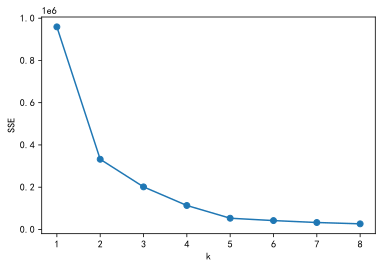

In [170]:
# 手肘法，利用SSE选择k
SSE = []  # 存放每次结果的误差平方和
for k in range(1,9):
    estimator = KMeans(n_clusters=k)  # 构造聚类器
    estimator.fit(data_scale)
    SSE.append(estimator.inertia_) # estimator.inertia_获取聚类准则的总和
X = range(1,9)
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(X,SSE,'o-')
plt.show()

0    2378
3      53
2      15
1       6
Name: labels, dtype: int64

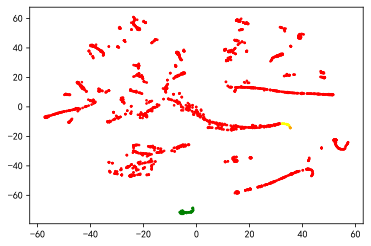

In [171]:
#用TSNE进行数据降维并展示聚类结果
from sklearn.manifold import TSNE

kmeans = KMeans(n_clusters=4).fit(data_scale)
display(pd.DataFrame(kmeans.labels_, columns=['labels'])['labels'].value_counts())

r = pd.concat([data, pd.Series(kmeans.labels_, index = data.index)], axis = 1) #详细输出每个样本对应的类别
r.columns = list(data.columns) + [u'聚类类别'] #重命名表头

tsne = TSNE()
tsne.fit_transform(data_scale) #进行数据降维,并返回结果
tsne = pd.DataFrame(tsne.embedding_, index = data_scale.index) #转换数据格式

#不同类别用不同颜色和样式绘图
cs = ['red','orange','yellow','green','cyan',
      'blue','purple','pink','magenta','brown']
for i in r['聚类类别'].unique():
    d = tsne[r['聚类类别']== i]  #找出聚类类别为0的数据对应的降维结果
    plt.scatter(d[0], d[1], color=cs[i], s=3)
plt.show()

In [172]:
r = pd.concat([ids, r], axis = 1)
r

,物料编号,物料类别,是否进口件,设备类型,周期（天）下计划后的交货周期,物料单位成本,分类,聚类类别
0,00556553000005X08,3,0,1,10.0,7900.00,3,0
1,00630560150001010,16,0,1,8.0,59.00,3,0
2,00630561850600000,29,0,1,12.0,643.00,3,0
3,00630561850800000,29,0,1,12.0,398.00,3,0
4,00630561851000000,29,0,1,12.0,202.00,3,0
...,...,...,...,...,...,...,...,...
2447,204110014,18,0,1,6.0,14.16,0,0
2448,207130011,18,0,1,6.0,71.00,0,0
2449,299000149,18,0,1,6.0,3.15,0,0
2450,WP81003000000001,9,0,1,12.0,1327.00,3,0


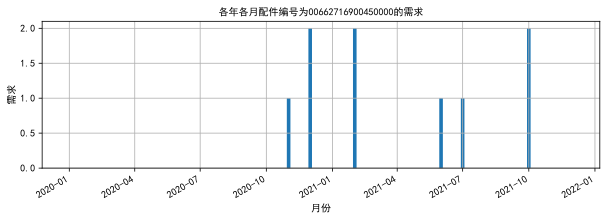

In [173]:
index = r.loc[r['聚类类别']==1, '物料编号'].values
# 各个物料按月可视化

matrl_full['day'] = 1
matrl_full['date'] = pd.to_datetime(matrl_full[['year', 'month', 'day']])
count = 0
for i in index:
    plot_monthly(matrl_full[matrl_full['物料编号']==i], 
                ylabel='月订单数量', 
                title='各年各月配件编号为'+i+'的需求')
    count = count + 1
    if count==1:
        break